In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import os
import glob
import seaborn as sns
import itertools
import gc
import pickle
from nptdms import TdmsFile
from scipy import stats
from natsort import natsorted
from tqdm import tqdm

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import scienceplots

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.usetex"] = True
# import seaborn as sns
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

np.random.seed(16)
matplotlib.rcParams['figure.dpi'] = 300

plt.style.use(['science','nature'])
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["Open","Arc","Short","Normal"])

import sys
sys.path.append('../.')
# from pydub import AudioSegment
import itertools
import string
import glob
import subprocess
import seedir
from utils.preprocessing import one_column,two_column,cm_std,cm_bright,cm_mark,cm_highCon,centimeter
from utils.preprocessing import print_tdms_structure,split_pulses_by_interval,getShiftMean
mpl.rcParams.update(two_column)
from MyDataset import sampling_rate_ae,sampling_rate_vib, project_dir, project_name, data_dir, dataDir_ae, dataDir_vib, alphabet

## Accuracy results

only difference in 

    - input_type


In [ ]:
allowed_input_types=[
    'ae_spec',
    'vib_spec',
    'ae_spec+ae_features',
    'vib_spec+vib_features',
    'ae_spec+ae_features+vib_spec+vib_features',
    'all'
    ]

model_name = []
folds = 10
repeat = 1
max_epochs = 9

In [16]:
def get_hist_data(hist_dir, model_name, folds, max_epochs=100):
    """
    Reads history CSVs for a model and extracts MSE and MAE from the final epoch.
    
    Args:
        hist_dir (str): Directory containing the history CSV files.
        model_name (str): The base name of the model.
        folds (int): The number of folds.
        max_epochs (int): The maximum number of epochs (used for reference, but the
                      function now robustly takes the last recorded epoch).

    Returns:
        tuple: Four lists containing train_mse, train_mae, test_mse, and test_mae
               for each fold.
    """
    train_mse, train_mae = [], []
    test_mse, test_mae = [], []

    for i in range(folds):
        file_path = os.path.join(hist_dir, f"{model_name}_fold{i}_of_folds{folds}.csv")
        df = pd.read_csv(file_path)

        # Get the last row of data, which corresponds to the final epoch's results
        last_epoch_data = df.iloc[-1]

        train_mse.append(last_epoch_data["train_mse"]/10)
        train_mae.append(last_epoch_data["train_mae"]/10)
        test_mse.append(last_epoch_data["test_mse"]/10)
        test_mae.append(last_epoch_data["test_mae"]/10)

    return train_mse, train_mae, test_mse, test_mae


def generate_hist_df(hist_dir, model_names, folds, max_epochs):
    """
    Generates a tidy DataFrame of model performance (MSE, MAE) across multiple
    folds and models, with separate entries for train and test sets.

    Args:
        hist_dir (str): Directory containing the history CSV files.
        model_names (list): A list of model base names to process.
        folds (int): The number of folds.
        max_epochs (int): The maximum number of epochs.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Input Type', 'Fold Index', 'Type', 
                      'MSE', 'MAE'].
    """
    all_records = []

    for model_name in model_names:
        # Fetch the metric lists for the current model
        train_mse_list, train_mae_list, test_mse_list, test_mae_list = get_hist_data(
            hist_dir, model_name, folds, max_epochs
        )

        # Create records for each fold
        for i in range(folds):
            # Append training data record
            all_records.append({
                'Input Type': model_name,
                'Fold Index': i,
                'Acc Type': 'Train',  # This column distinguishes between train/test
                'MSE': train_mse_list[i],
                'MAE': train_mae_list[i]
            })
            # Append testing data record
            all_records.append({
                'Input Type': model_name,
                'Fold Index': i,
                'Acc Type': 'Test',
                'MSE': test_mse_list[i],
                'MAE': test_mae_list[i]
            })

    # Convert the list of records into a single DataFrame
    df = pd.DataFrame(all_records)
    return df

In [17]:
his_dir = os.path.join(os.pardir,"lfs","train_his")
df = generate_hist_df(his_dir,allowed_input_types,folds=folds,max_epochs=max_epochs)
df

,Input Type,Fold Index,Acc Type,MSE,MAE
0,ae_spec,0,Train,1741.571245,13.348607
1,ae_spec,0,Test,1385.637817,9.975049
2,ae_spec,1,Train,1010.057339,10.257385
3,ae_spec,1,Test,1289.233844,8.164131
4,ae_spec,2,Train,1137.197109,9.508212
...,...,...,...,...,...
115,all,7,Test,532.977769,3.483322
116,all,8,Train,490.212634,5.534109
117,all,8,Test,291.342822,3.124278
118,all,9,Train,1334.949244,7.833099


/tmp/ipykernel_94218/1120689686.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
/tmp/ipykernel_94218/1120689686.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels])


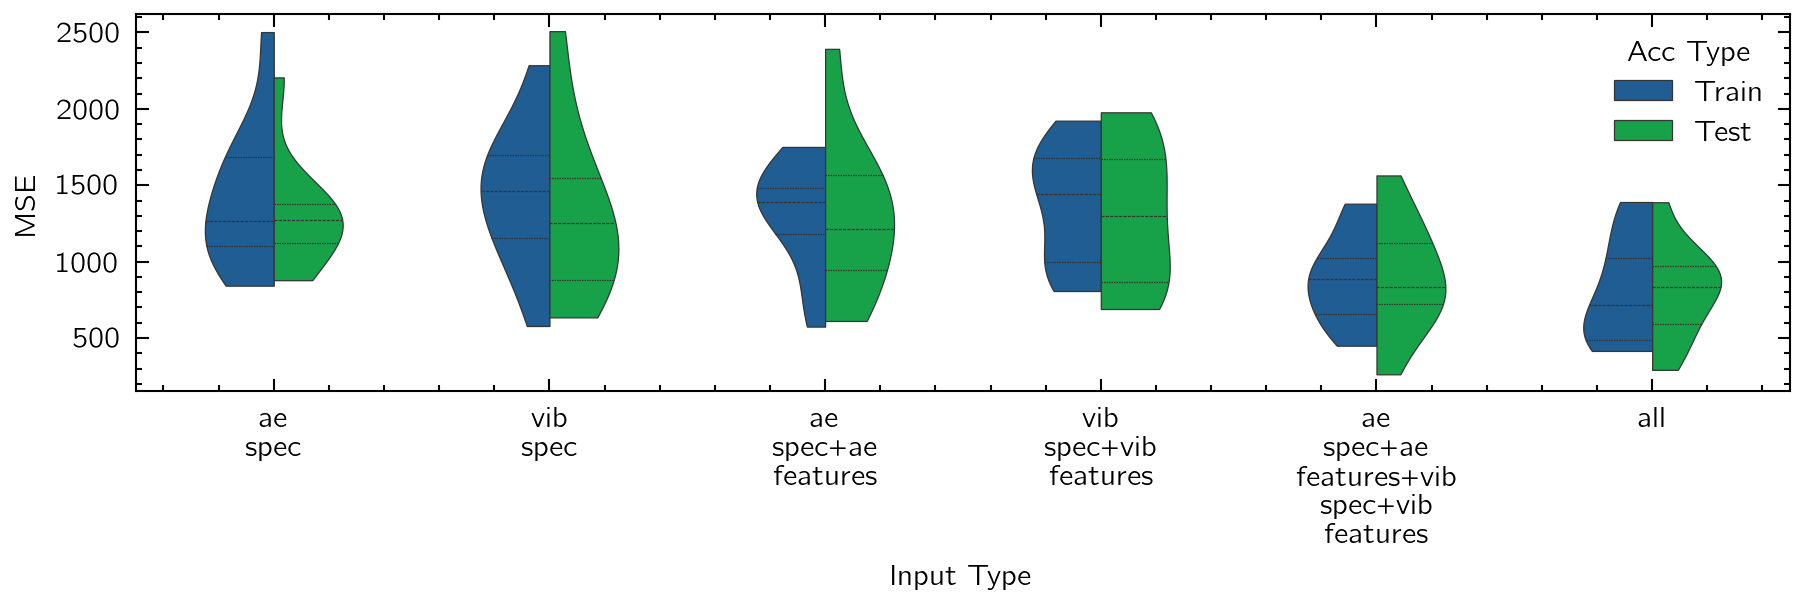

/tmp/ipykernel_94218/1120689686.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
/tmp/ipykernel_94218/1120689686.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels])


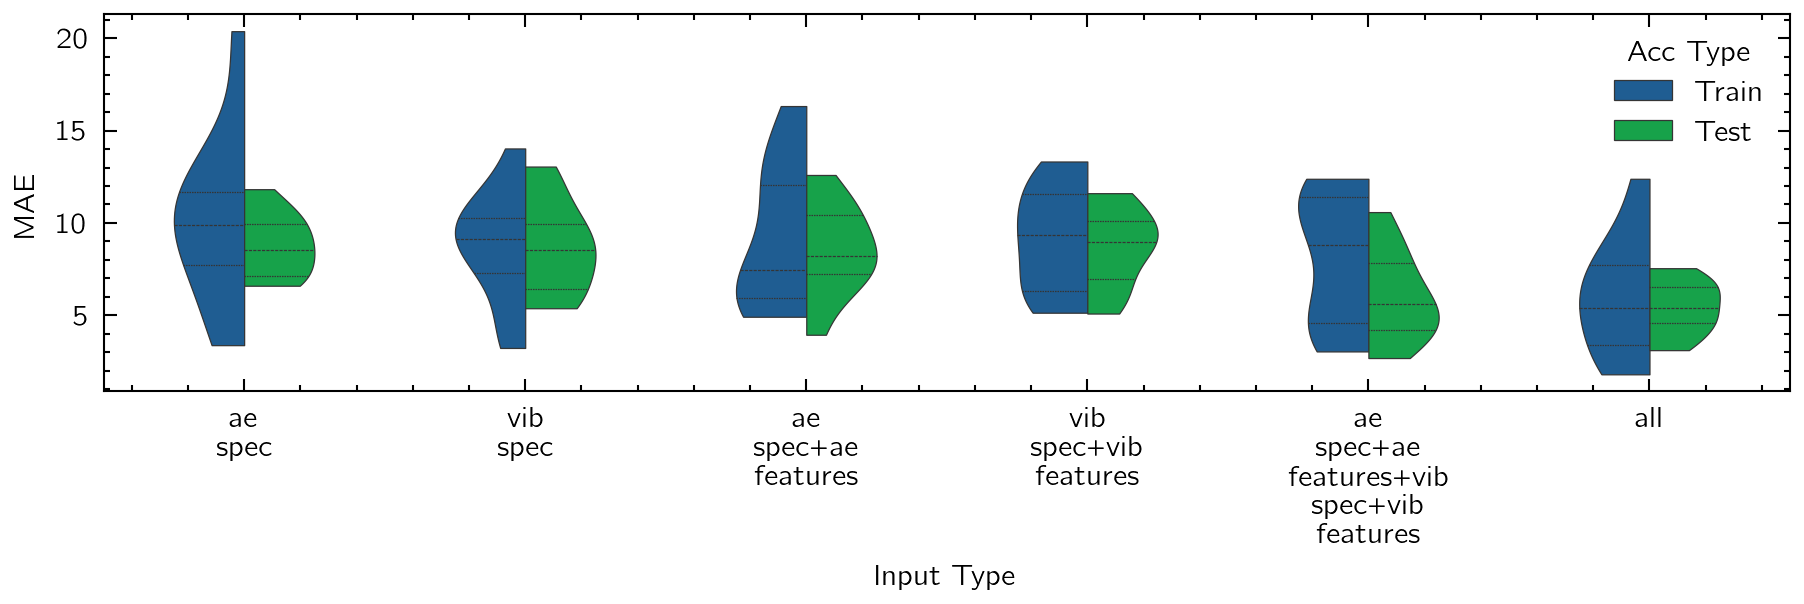

In [19]:
for _y in ["MSE", "MAE"]:
    plt.rcParams.update(one_column)
    plt.rcParams['figure.constrained_layout.use'] = True
    fig,ax = plt.subplots(figsize=(6.0,2))
    snsdf = sns.load_dataset("tips")
    ax = sns.violinplot(
        # data=df[df["Model"]=="CNN"],
        data=df,
        x="Input Type",
        y=_y,
        hue="Acc Type",
        split=True,
        saturation=0.75,
        density_norm="width",
        hue_order=["Train", "Test"],
        dodge=True,
        inner='quartile',
        ax=ax,
        linewidth=0.3,
        width = 0.5,
        palette = ["#0C5EA5FF", "#00B944FF", 'yellow'],
        cut=0
    )
    # ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
    xTickLabels = allowed_input_types
    ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels]) 
    ax.set_ylabel(_y)
    plt.savefig(os.path.join(os.pardir,"Grinding Fusion","images",f"raw_{_y}vs_model.png"),dpi=300)
    plt.show()